#Fast campus EDA 아이데이션 초급5조

##I.작업순서
 1.데이터 분석 문제 정의<br>

 2.베이스라인 선정<br>

 3.데이터 수집 및 정제

 4.탐색적 데이터 분석

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='NanumBarunGothic')

In [ ]:
# 한글 폰트 사용하기 위한 코드

plt.rc('font', family='AppleGothic')
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
#확인
import matplotlib.font_manager as fm
[(f.name, f.fname) for f in fm.fontManager.ttflist if 'NanumBarun' in f.name]

[('NanumBarunGothic', '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'),
 ('NanumBarunGothic',
  '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf')]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df_origin = pd.read_excel('/content/drive/MyDrive/5/팀프로젝트/rawdata.xlsx')
display(df_origin.head(2) )
df = df_origin.copy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,customer_id,course_id,type,state,course_title,category_title,format,completed_at,transaction_amount,coupon_title,coupon_discount_amount,sale_price,tax_free_amount,pg,method,subcategory_title,marketing_start_at
0,970634,504760.0,201435.0,ORDER,CANCELLED,올인원 패키지 : 알고리즘 기술면접 완전 정복,프로그래밍,올인원,2021-03-28 15:00:11,90500,NaN,NaN,110500.0,110500.0,NaN,VBANK,개발자 커리어,NaT
1,970650,432862.0,203178.0,ORDER,CANCELLED,초격차 패키지 : 한번에 끝내는 영상 촬영과 편집,영상/3D,올인원,2021-03-28 15:16:53,96000,NaN,NaN,116000.0,116000.0,NaN,CARD,영상 편집,2020-12-02


id : 아이디

customer_id : 고객 아이디

course_id : 코스 아이디

type : 고객상태(오더/페이먼트)

state : 고객상태(타입결과:페이)

course_title : 코스이름

category_title : 강의카테고리

format : 강의 패키지 이름 

completed_at : 결제가 완료된 시각

transaction_amount : 가격

coupon_title : (할인)쿠폰 이름 

coupon_discount_amount : (할인)쿠폰 가격 

sale_price : 할인가격

tax_free_amount :교육비 세액공제 비용 

pg : 결제모듈회사

method : 결제방법

subcategory_title : 강의 서브 카테고리

marketing_start_at :판매가 시작된 날짜  (공란은 무시)

columns에 대한 설명

id : 아이디 <br>
customer_id : 고객 아이디<br>
course_id : 코스 아이디<br>
type : 고객상태(오더/페이먼트)<br>
- order : 결제 페이지는 갔지만 결제하지 않은 상태
- payment : 최종 결제가 일어난 상태
- refund : 환불
- completed : 결제 완료

state : 고객상태(타입결과:페이)<br>
- deleted : 테이블에서 제거해야하는 상태
- cancelled : 결제가 취소된 상태
- pending : pg사에서 결제 완료가 안된 상태
- complete : pg 처리까지 완료된 상태

course_title : 코스이름<br>
category_title : 강의카테고리<br>
format : 강의 패키지 이름 <br>
completed_at : 결제가 완료된 시각<br>
transaction_amount : 최종 결제 금액<br>
coupon_title : (할인)쿠폰 이름 <br>
coupon_discount_amount : (할인)쿠폰 가격 <br>
sale_price : 할인가격<br>
tax_free_amount :교육비 세액공제 비용 <br>
pg : 결제모듈회사(카카오페이, 토스 등), 공백은 PG사를 의미<br>
method : 결제방법<br>
subcategory_title : 강의 서브 카테고리<br>
marketing_start_at :판매가 시작된 날짜(즉, landing page가 최초로 올라간 시점)  (공란은 무시)<br>

<카테고리별>

카테고리별 [‘category_title’], [‘type’], [‘state’] / 전체, B2B, B2C 별 데이터 분석

- 전체, B2B, B2C 별 선호도(구매 확정 중 많은 비율을 차지하는 카테고리 Top 3)

- 전체, B2B, B2C 별 가격 평균 or 중앙값(이상치 여부에 따라 판단) 

- 전체, B2B, B2C 별 매출(구매 확정 금액 - 환불 확정 금액) 

type = payment & state = completed (구매 확정)

type = refund & state = completed (환불 확정) 

-> 선호도, 가격 평균(or 중앙값), 매출을 통해 카테고리에 따른 B2B, B2C별 마케팅 방향성 제시


### 카테고리별 전체, B2B, B2C 데이터 전처리

진행 순서 

1. 최종 결제된 경우로 데이터를 분석하기 위해 해당 조건들로 데이터프레임을 만들겠습니다.
    - type이 refund, transaction, order인 경우 제외
    - state이 completed가 아닌 경우 제외

2. 결측치 데이터 전처리

In [ ]:
df = df_origin.copy()
df['type_state'] = df[['type', 'state']].agg('.'.join, axis=1)

df_pay_com = df.loc[df.type_state == 'PAYMENT.COMPLETED', :].reset_index(drop=True)
df_ref_com = df.loc[df.type_state == 'REFUND.COMPLETED', :].reset_index(drop=True)

# category_title 전처리: category_title이 null인 3개 row 제거합니다.
df_pay_com = df_pay_com.dropna(subset=['category_title'])

# 데이터사이언스와 데이터 사이언스를 '데이터사이언스'로 합치겠습니다.
df_pay_com2 = df_pay_com.replace(to_replace='데이터 사이언스', value='데이터사이언스')

#B2B(기업 고객)인 경우와 B2C(개인 결제 고객)인 경우를 나누겠습니다.
df_pc_b2b = df_pay_com2.loc[df_pay_com2.course_title.str.contains('B2B'), :].reset_index(drop=True)
df_pc_b2c = df_pay_com2.loc[~df_pay_com2.course_title.str.contains('B2B'), :].reset_index(drop=True)

# 환불인 경우 중 기업고객(B2B) 개인고객(B2C)인 경우
df_rc_b2b = df_ref_com.loc[df_ref_com.course_title.str.contains('B2B'), :].reset_index(drop=True)
df_rc_b2c = df_ref_com.loc[~df_ref_com.course_title.str.contains('B2B'), :].reset_index(drop=True)

결제된 내역 중 카테고리별 분석을 위한 데이터 전처리 과정이 끝났습니다.

#EDA 시작

#I.매출현황분석

분석 - 월별 매출


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0, flags=flags)


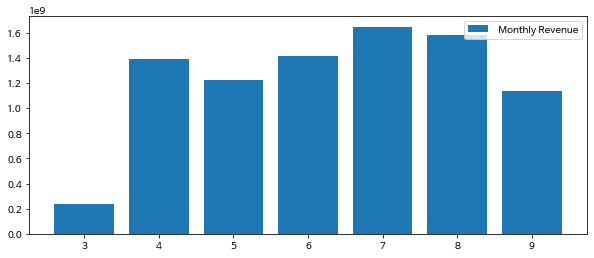

monthbymonth
3     235919990
4    1387643596
5    1226867911
6    1411925695
7    1648158751
8    1583177289
9    1136283180
Name: transaction_amount, dtype: int64

In [ ]:
print("분석 - 월별 매출")
df_count = df_pay_com2.copy()
df_count['monthbymonth'] = df_count['completed_at'].dt.month
y = df_count.groupby('monthbymonth')['transaction_amount'].sum()
x = df_count['monthbymonth'].unique()

plt.figure(figsize=(10, 4))
plt.bar(x, y, label="Monthly Revenue")
plt.legend(loc="upper right")
plt.show()

df_count.groupby('monthbymonth')['transaction_amount'].sum()

In [ ]:
print("<전체매출>  기간내 전체 매출")
# 카테고리별 환불 금액 총합
a = df_ref_com.groupby('category_title').agg({'transaction_amount':np.sum})
# 카테고리별 구매 금액 총합
b = df_pay_com2.groupby('category_title').agg({'transaction_amount':np.sum})
# 환불 금액, 구매 금액 하나의 데이터프레임으로 생성
df_revenue = pd.merge(a,b, how='outer', on='category_title')
# 금액을 합쳐서 카테고리별 매출을 구하기 위해 결측치는 0으로 변환
df_revenue = df_revenue.fillna(0)
# 카테고리별 환불 금액과 구매 금액을 합친 매출 금액 columns을 생성
df_revenue['cate_profit'] = df_revenue.transaction_amount_x + df_revenue.transaction_amount_y 
df_revenue

<전체매출>  기간내 전체 매출


,transaction_amount_x,transaction_amount_y,cate_profit
category_title,,,
교육,-1600000.0,1161925545,1.160326e+09
데이터사이언스,-93439153.0,1614341252,1.520902e+09
디자인,-66463452.0,729661620,6.631982e+08
마케팅,-75983126.0,810588950,7.346058e+08
부동산/금융,-28484791.0,504129225,4.756444e+08
비즈니스,-660000.0,6049865,5.389865e+06
업무 생산성,-41798875.0,636828300,5.950294e+08
영상/3D,-46737195.0,591443400,5.447062e+08
크리에이티브,-37372473.0,338428300,3.010558e+08


In [ ]:
print("<b2b매출> 기간내 기업고객(B2B)인 경우")
# 기업고객(B2B)의 카테고리별 매출 파악
c = df_rc_b2b.groupby('category_title').agg({'transaction_amount':np.sum})
d = df_pc_b2b.groupby('category_title').agg({'transaction_amount':np.sum})
# 환불 금액, 구매 금액 하나의 데이터프레임으로 생성
df_b2b_revenue = pd.merge(c,d , how='outer', on='category_title')
# 금액을 합쳐서 카테고리별 매출을 구하기 위해 결측치는 0으로 변환
df_b2b_revenue = df_b2b_revenue.fillna(0)
# 카테고리별 환불 금액과 구매 금액을 합친 매출 금액 columns을 생성
df_b2b_revenue['cate_profit'] = df_b2b_revenue.transaction_amount_x + df_b2b_revenue.transaction_amount_y 
df_b2b_revenue

<b2b매출> 기간내 기업고객(B2B)인 경우


,transaction_amount_x,transaction_amount_y,cate_profit
category_title,,,
교육,-1600000.0,1161925545,1.160326e+09
디자인,-407000.0,3269800,2.862800e+06
크리에이티브,-480000.0,63553500,6.307350e+07
프로그래밍,-7929990.0,80563300,7.263331e+07
데이터사이언스,0.0,541879554,5.418796e+08
마케팅,0.0,146982500,1.469825e+08
부동산/금융,0.0,2177500,2.177500e+06
비즈니스,0.0,360000,3.600000e+05
업무 생산성,0.0,25265200,2.526520e+07


In [ ]:
print("<b2c매출> 기간내 개인고객(B2C)인 경우")
# 개인고객(B2C)의 카테고리별 매출 파악
e = df_rc_b2c.groupby('category_title').agg({'transaction_amount':np.sum})
f = df_pc_b2c.groupby('category_title').agg({'transaction_amount':np.sum})
# 환불 금액, 구매 금액 하나의 데이터프레임으로 생성
df_b2c_revenue = pd.merge(e,f , how='outer', on='category_title')
# 금액을 합쳐서 카테고리별 매출을 구하기 위해 결측치는 0으로 변환
df_b2c_revenue = df_b2c_revenue.fillna(0)
# 카테고리별 환불 금액과 구매 금액을 합친 매출 금액 columns을 생성
df_b2c_revenue['cate_profit'] = df_b2c_revenue.transaction_amount_x + df_b2c_revenue.transaction_amount_y 
df_b2c_revenue

<b2c매출> 기간내 개인고객(B2C)인 경우


,transaction_amount_x,transaction_amount_y,cate_profit
category_title,,,
데이터사이언스,-93439153.0,1072461698,9.790225e+08
디자인,-66056452.0,726391820,6.603354e+08
마케팅,-75983126.0,663606450,5.876233e+08
부동산/금융,-28484791.0,501951725,4.734669e+08
비즈니스,-660000.0,5689865,5.029865e+06
업무 생산성,-41798875.0,611563100,5.697642e+08
영상/3D,-46737195.0,591443400,5.447062e+08
크리에이티브,-36892473.0,274874800,2.379823e+08
투자/재테크,-26842980.0,304549400,2.777064e+08


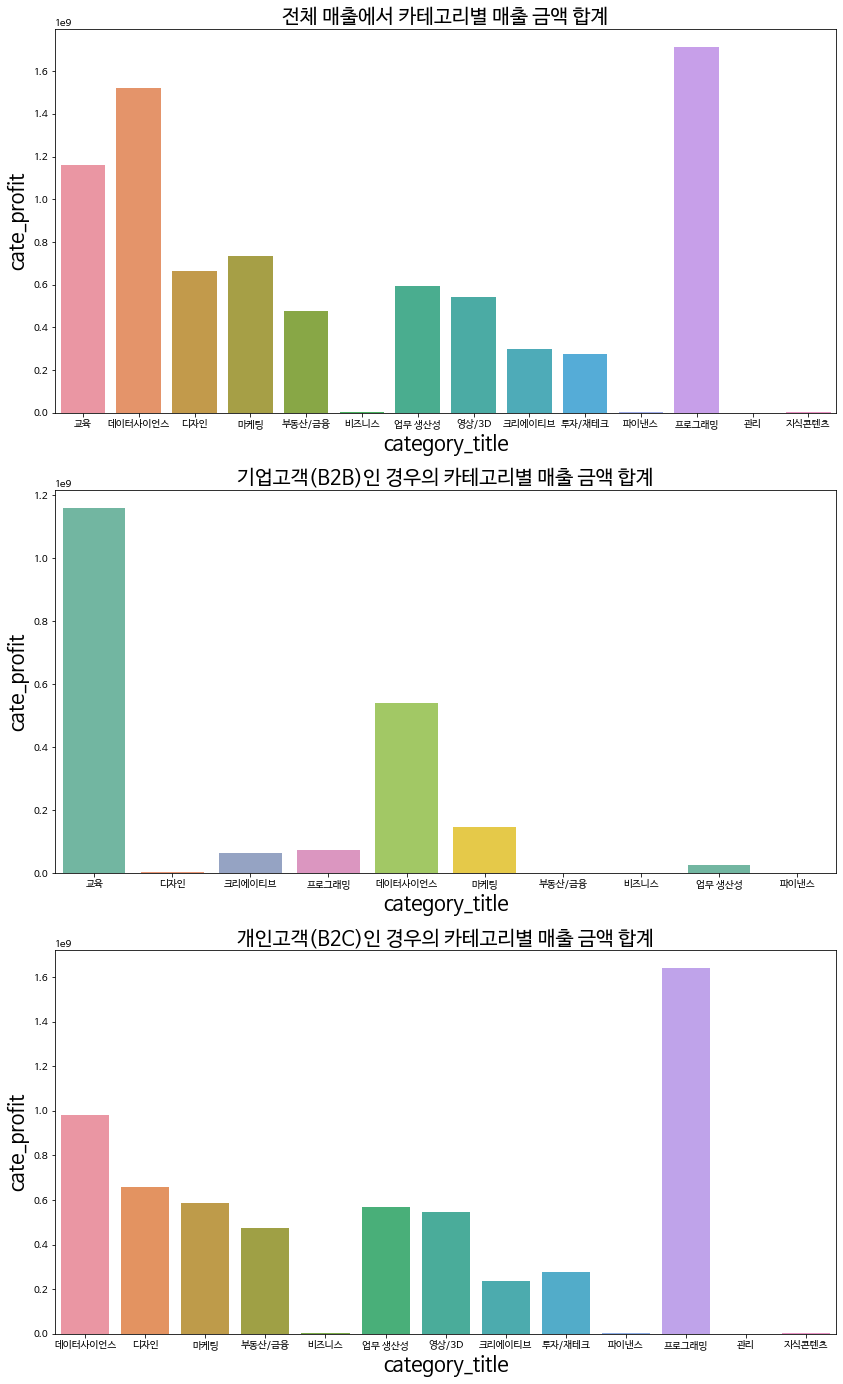

In [ ]:
# 전체, B2B, B2C의 카테고리별 매출 금액 합계

plt.figure(figsize=(14,24))

plt.subplot(3,1,1)
sns.barplot(data=df_revenue, x=df_revenue.index, y='cate_profit')
plt.title('전체 매출에서 카테고리별 매출 금액 합계', fontsize=20)
plt.xlabel('category_title', fontsize = 20)
plt.ylabel('cate_profit', fontsize = 20)

plt.subplot(3,1,2)
sns.barplot(data=df_b2b_revenue, x=df_b2b_revenue.index, y='cate_profit', palette = 'Set2')
plt.title('기업고객(B2B)인 경우의 카테고리별 매출 금액 합계', fontsize=20)
plt.xlabel('category_title', fontsize = 20)
plt.ylabel('cate_profit', fontsize = 20)

plt.subplot(3,1,3)
sns.barplot(data=df_b2c_revenue, x=df_b2c_revenue.index, y='cate_profit')
plt.title('개인고객(B2C)인 경우의 카테고리별 매출 금액 합계', fontsize=20)
plt.xlabel('category_title', fontsize = 20)
plt.ylabel('cate_profit', fontsize = 20)

plt.show()

#II.카테고리별 선호도 분석(선호도, 비선호도, 환불 분석)

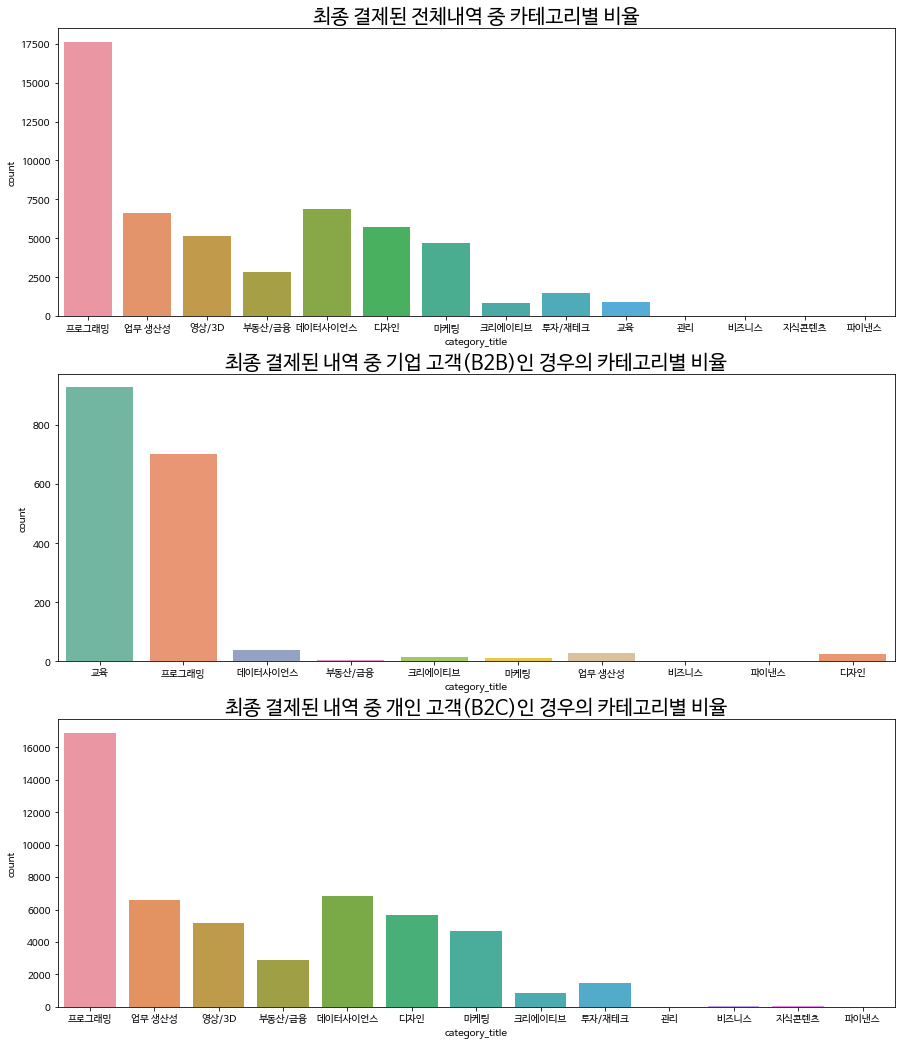

In [ ]:
plt.figure(figsize=(15,18))
plt.subplot(3,1,1)
sns.countplot(data=df_pay_com2, x='category_title')
plt.title('최종 결제된 전체내역 중 카테고리별 비율', fontsize = 20)
plt.subplot(3,1,2)
sns.countplot(data=df_pc_b2b, x='category_title', palette = 'Set2')
plt.title('최종 결제된 내역 중 기업 고객(B2B)인 경우의 카테고리별 비율', fontsize = 20)
plt.subplot(3,1,3)
sns.countplot(data=df_pc_b2c, x='category_title')
plt.title('최종 결제된 내역 중 개인 고객(B2C)인 경우의 카테고리별 비율', fontsize = 20)
plt.show()

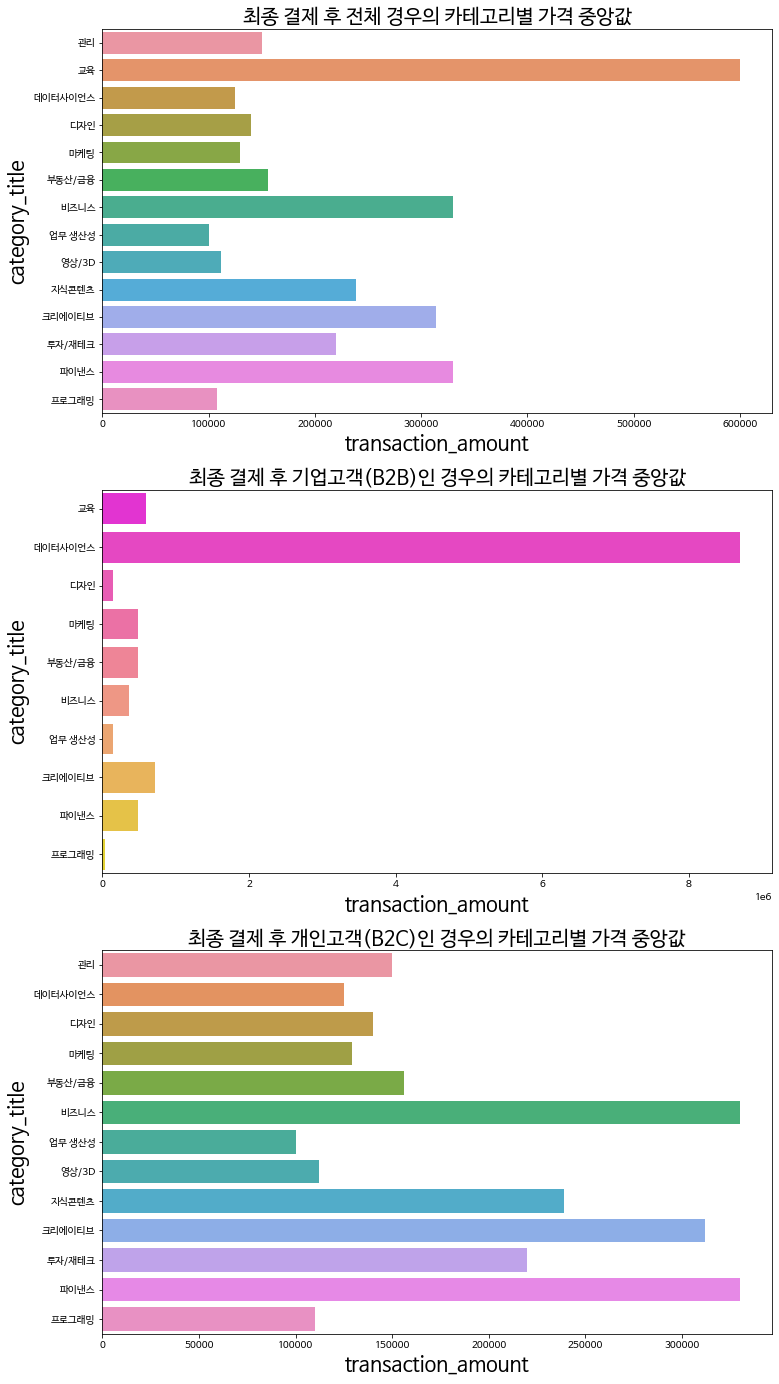

In [ ]:
df_pay_com2_medi = df_pay_com2.groupby('category_title').agg({'transaction_amount' : np.median}) # 전체 고객 카테고리별 가격 중앙값
df_b2b_medi = df_pc_b2b.groupby('category_title').agg({'transaction_amount' : np.median}) # 기업 고객 카테고리별 가격 중앙값 
df_b2c_medi = df_pc_b2c.groupby('category_title').agg({'transaction_amount' : np.median}) # 개인 고객 카테고리별 가격 중앙값

# 중앙값(median)을 비교해보겠습니다.
plt.figure(figsize=(12,24))
plt.subplot(3,1,1)
sns.barplot(data=df_pay_com2_medi, x='transaction_amount', y=df_pay_com2_medi.index)
plt.title('최종 결제 후 전체 경우의 카테고리별 가격 중앙값', fontsize=20)
plt.xlabel('transaction_amount', fontsize = 20)
plt.ylabel('category_title', fontsize = 20)
plt.subplot(3,1,2)
sns.barplot(data=df_b2b_medi, x='transaction_amount', y=df_b2b_medi.index, palette='spring')
plt.title('최종 결제 후 기업고객(B2B)인 경우의 카테고리별 가격 중앙값', fontsize=20)
plt.xlabel('transaction_amount', fontsize = 20)
plt.ylabel('category_title', fontsize = 20)
plt.subplot(3,1,3)
sns.barplot(data=df_b2c_medi, x='transaction_amount', y=df_b2c_medi.index)
plt.title('최종 결제 후 개인고객(B2C)인 경우의 카테고리별 가격 중앙값', fontsize=20)
plt.xlabel('transaction_amount', fontsize = 20)
plt.ylabel('category_title', fontsize = 20)
plt.show()

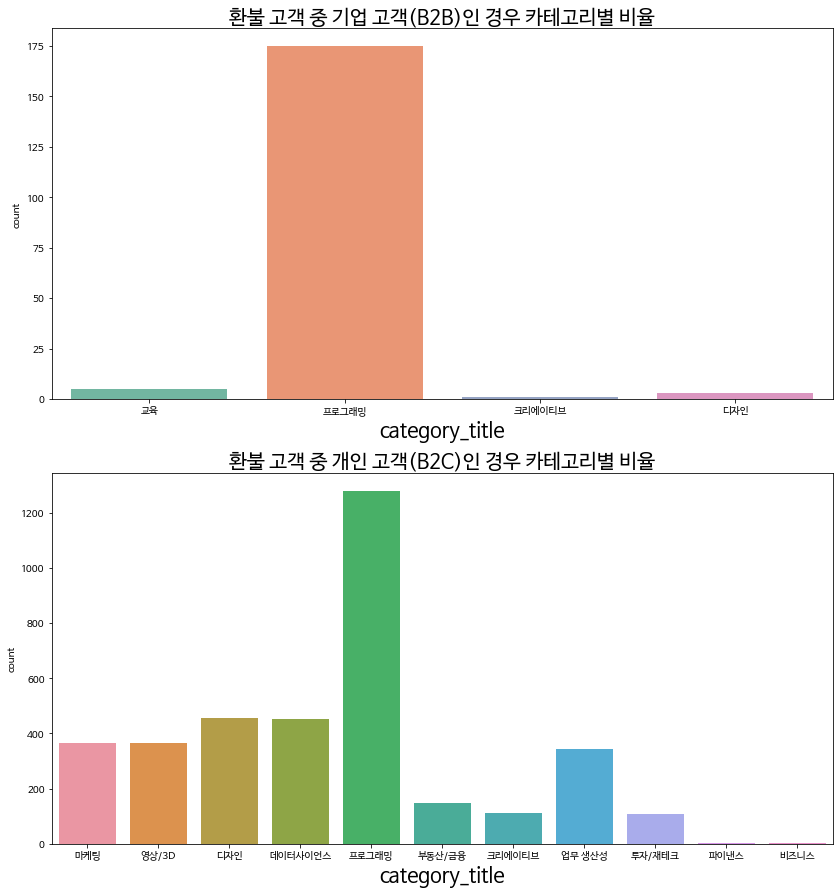

In [ ]:
# 환불된 강의 카테고리별 비율
plt.figure(figsize=(14,15))
plt.subplot(2,1,1)
sns.countplot(data=df_rc_b2b, x='category_title',palette='Set2')
plt.title('환불 고객 중 기업 고객(B2B)인 경우 카테고리별 비율', fontsize=20)
plt.xlabel('category_title', fontsize = 20)
plt.subplot(2,1,2)
sns.countplot(data=df_rc_b2c, x='category_title')
plt.title('환불 고객 중 개인 고객(B2C)인 경우 카테고리별 비율', fontsize=20)
plt.xlabel('category_title', fontsize = 20)
plt.show()

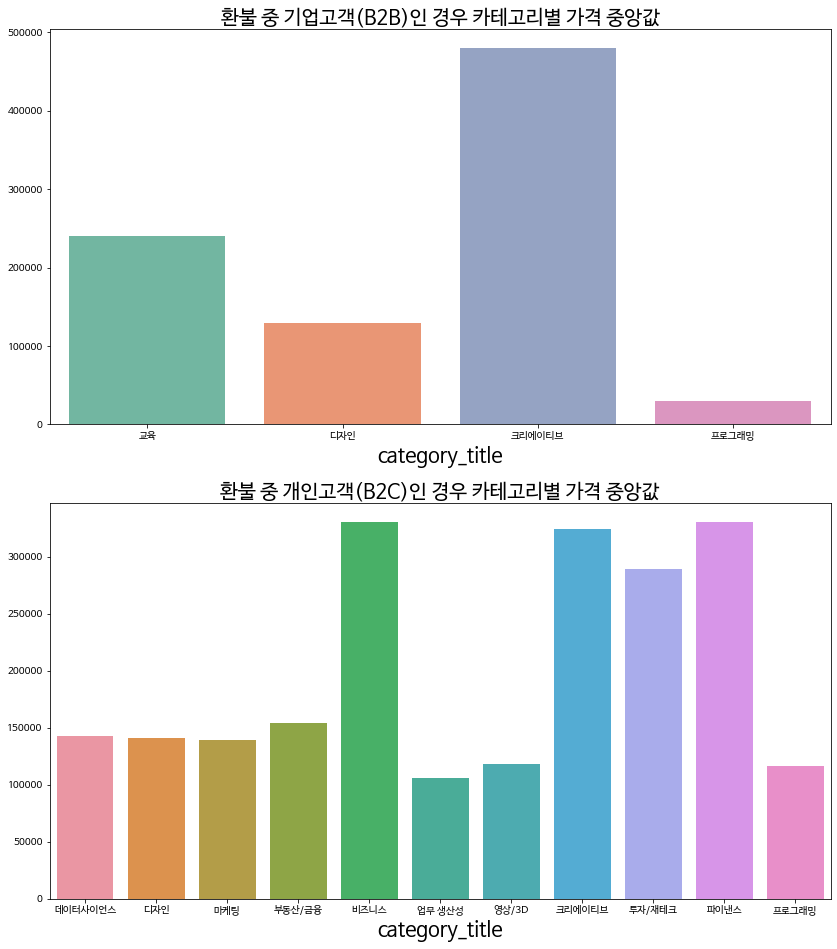

In [ ]:
df_rc_b2b_medi = df_rc_b2b.groupby('category_title').agg({'transaction_amount' : np.median}) # 기업 고객 카테고리별 환불된 가격 중앙값
df_rc_b2c_medi = df_rc_b2c.groupby('category_title').agg({'transaction_amount' : np.median}) # 개인 고객 카테고리별 환불된 가격 중앙값

# 중앙값(median)을 비교해보겠습니다.
plt.figure(figsize=(14,16))
plt.subplot(2,1,1)
y= abs(df_rc_b2b_medi.transaction_amount.values)
sns.barplot(data=df_rc_b2b_medi, x=df_rc_b2b_medi.index, y=y, palette = 'Set2')
plt.title('환불 중 기업고객(B2B)인 경우 카테고리별 가격 중앙값', fontsize=20)
plt.xlabel('category_title', fontsize = 20)
plt.subplot(2,1,2)
y= abs(df_rc_b2c_medi.transaction_amount.values)
sns.barplot(data=df_rc_b2c_medi, x=df_rc_b2c_medi.index, y=y)
plt.title('환불 중 개인고객(B2C)인 경우 카테고리별 가격 중앙값', fontsize=20)
plt.xlabel('category_title', fontsize = 20)
plt.show()

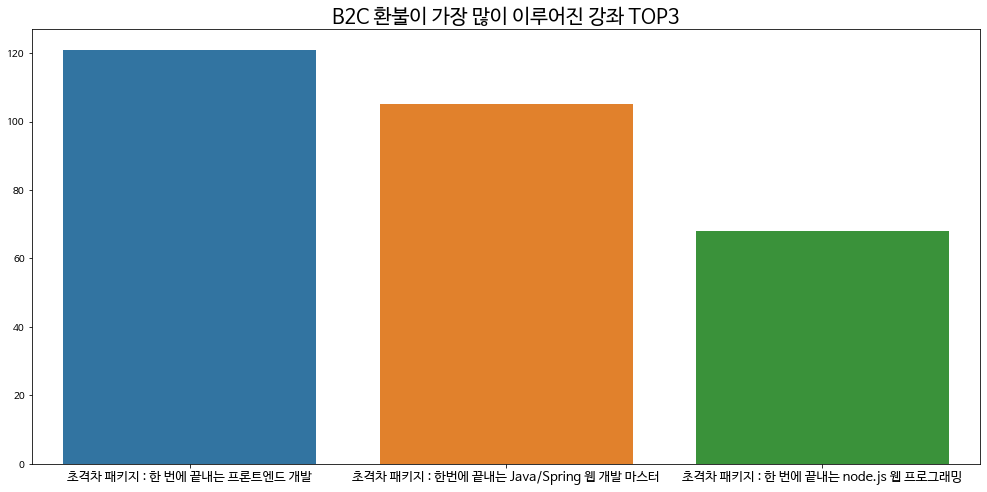

In [ ]:
plt.figure(figsize=(17,8))
sns.barplot(data=df_rc_b2c, x=df_rc_b2c.course_title.value_counts().head(3).index, y=df_rc_b2c.course_title.value_counts().head(3).values)
plt.xticks(fontsize=13)
plt.title('B2C 환불이 가장 많이 이루어진 강좌 TOP3', fontsize=20)
plt.show()

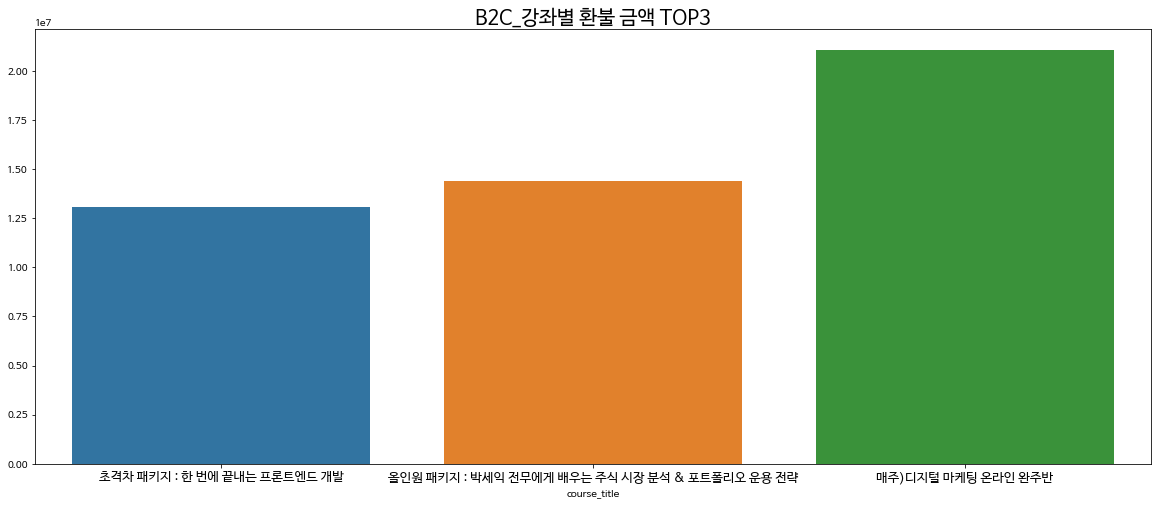

In [ ]:
plt.figure(figsize=(20, 8))
df_rc_b2c['count'] = 1 
x = df_rc_b2c.groupby('course_title')["transaction_amount"].sum().sort_values(ascending=False).tail(3).index
y = sorted(abs(df_rc_b2c.groupby('course_title')['transaction_amount'].sum()))[-3:]
sns.barplot(x=x, y=y,data=df_rc_b2c)
plt.title('B2C_강좌별 환불 금액 TOP3', fontsize = 20)
plt.xticks(fontsize=13)
plt.show()

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

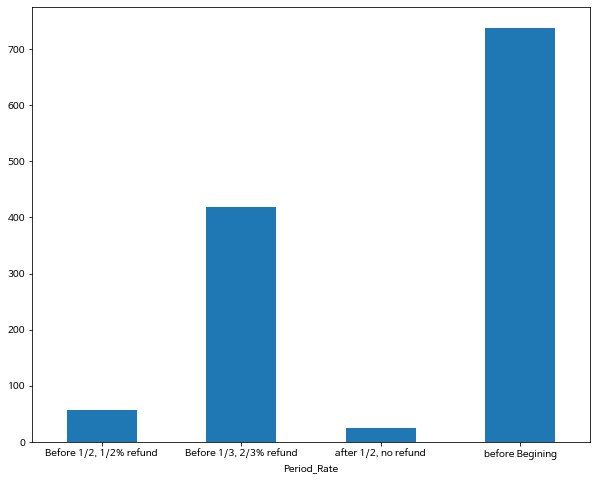

In [ ]:
df_rc_b2c = df_rc_b2c.copy()
from operator import contains
spac = df_rc_b2c[~df_rc_b2c['course_title'].str.contains("초격차 패키지")].index
df_rc_b2c.drop(spac, inplace=True)
df_rc_b2c
df_rc_b2c['Percentage'] = df_rc_b2c['transaction_amount']/df_rc_b2c['sale_price'] * 100
df_rc_b2c['Percentage'] = df_rc_b2c['Percentage'].astype(int)
df_rc_b2c['Percentage'] =np.abs(df_rc_b2c['Percentage'])
def my_life(x):
  if 90 <= x and x <= 100:
    return "before Begining" 
  elif 67 <= x and x <= 89:
    return "Before 1/3, 2/3% refund"
  elif 50 <= x and x <= 66:
    return "Before 1/2, 1/2% refund" 
  else:
    return "after 1/2, no refund"
df_rc_b2c["Period_Rate"] = df_rc_b2c['Percentage'].apply(my_life)
df_rc_b2c['count']=1
df_rc_b2c.groupby("Period_Rate")['count'].sum().plot(kind='bar', figsize=(10,8))
plt.xticks(rotation=0, fontsize=10)

#III.마케팅 데이터 분석

결측치를 최소값으로 변환
marketing_start_at 결측치 9341
completed_at 결측치 0
marketing_start_at 결측치 0

이상치 수정
시작날짜값이 끝날짜값보다 더 뒤인 이상치의 수:  8
시작날짜값이 끝날짜값보다 더 뒤인 이상치의 수:  0


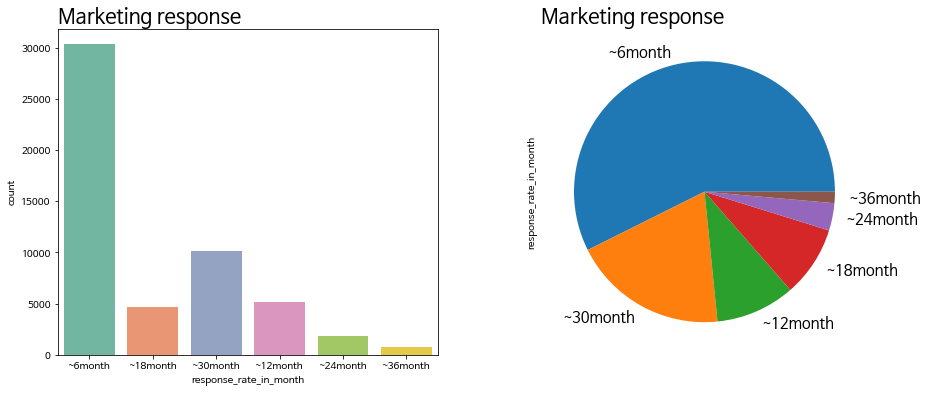

52899건의 전체 건수 중에서
30347건이 마케팅이 시작하고 6개월 이내에 결제하었으며
6개월 이내에 결제한 건은 총30347건, 57.37%
12개월 이내에 결제한 건은 총5205건, 9.84%


In [ ]:
#마케틸 부터 결제일까지의 날짜 month로 계산하여 분류화
df_response = df_pay_com.copy()
# 날짜 전처리
print("결측치를 최소값으로 변환")
print('marketing_start_at 결측치', sum(df_response['marketing_start_at'].isnull()) ) #날짜 값에 결측치가 10055개가 있음
print('completed_at 결측치', sum(df_response['completed_at'].isnull()) )
df_response.loc[df_response['marketing_start_at'].isnull(), 'marketing_start_at'] = df_response['marketing_start_at'].min()   #최소값
print('marketing_start_at 결측치', sum(df_response['marketing_start_at'].isnull()) ) #전처리 확인
print("")
print("이상치 수정")
print("시작날짜값이 끝날짜값보다 더 뒤인 이상치의 수: ", sum( (df_response['marketing_start_at'] > df_response['completed_at'])  ) )  # 8개 값이 마케틸 시작 날짜가 결제 날짜보다 늦은 내용. 확인해보니 12시간 차이 나지 않는 내용들. marketing_start_at = completed_at 처리
df_response.loc[ (df_response['marketing_start_at'] > df_response['completed_at']) , 'marketing_start_at'] = df_response['completed_at']
print("시작날짜값이 끝날짜값보다 더 뒤인 이상치의 수: ", sum( (df_response['marketing_start_at'] > df_response['completed_at'])  ) )

df_response["marketing_dusration_in_month"] = (df_response["completed_at"] - df_response["marketing_start_at"]).dt.days / 30     #dtype: timedelta64  --> int64     #결과 0일 ~ 1023일     #새로 컬럼 추가
def funx(x) :
  if (0<=x) & (x<7) :
    return "~6month"
  elif (7<=x) & (x<13) :
    return "~12month"
  elif (13<=x) & (x<19) :
    return "~18month"
  elif (19<=x) & (x<25) :
    return "~24month"
  elif (25<=x) & (x<31) :
    return "~30month"
  elif (31<=x) & (x<37) :
    return "~36month"
  else :
    return "Not_related"
df_response['response_rate_in_month'] = df_response['marketing_dusration_in_month'].apply(funx) #새로 컬럼 추가

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title("Marketing response", fontsize=20, loc="left")
sns.countplot(data=df_response, x="response_rate_in_month", palette="Set2")
plt.subplot(1,2,2)
plt.title("Marketing response", fontsize=20, loc="left")
df_response['response_rate_in_month'].value_counts().plot.pie(fontsize=15)
plt.show()

print( str(len(df_response)) +"건의 전체 건수 중에서" )
print( str(df_response[df_response['response_rate_in_month']=="~6month"]['response_rate_in_month'].count()) +"건이 마케팅이 시작하고 6개월 이내에 결제하었으며"  )
print( "6개월 이내에 결제한 건은 총"+ str(len(df_response[df_response['response_rate_in_month']=="~6month"])) +"건, "+    str(round(len(df_response[df_response['response_rate_in_month']=="~6month"])/len(df_response['response_rate_in_month'])*100,2)) +"%")
print(  "12개월 이내에 결제한 건은 총"+ str(len(df_response[df_response['response_rate_in_month']=="~12month"])) +"건, "+   str(round(len(df_response[df_response['response_rate_in_month']=="~12month"])/len(df_response['response_rate_in_month'])*100,2)) +"%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


count                   52899
unique                    172
top       2019-02-19 00:00:00
freq                     9534
first     2019-02-19 00:00:00
last      2021-09-16 00:00:00
Name: marketing_start_at, dtype: object

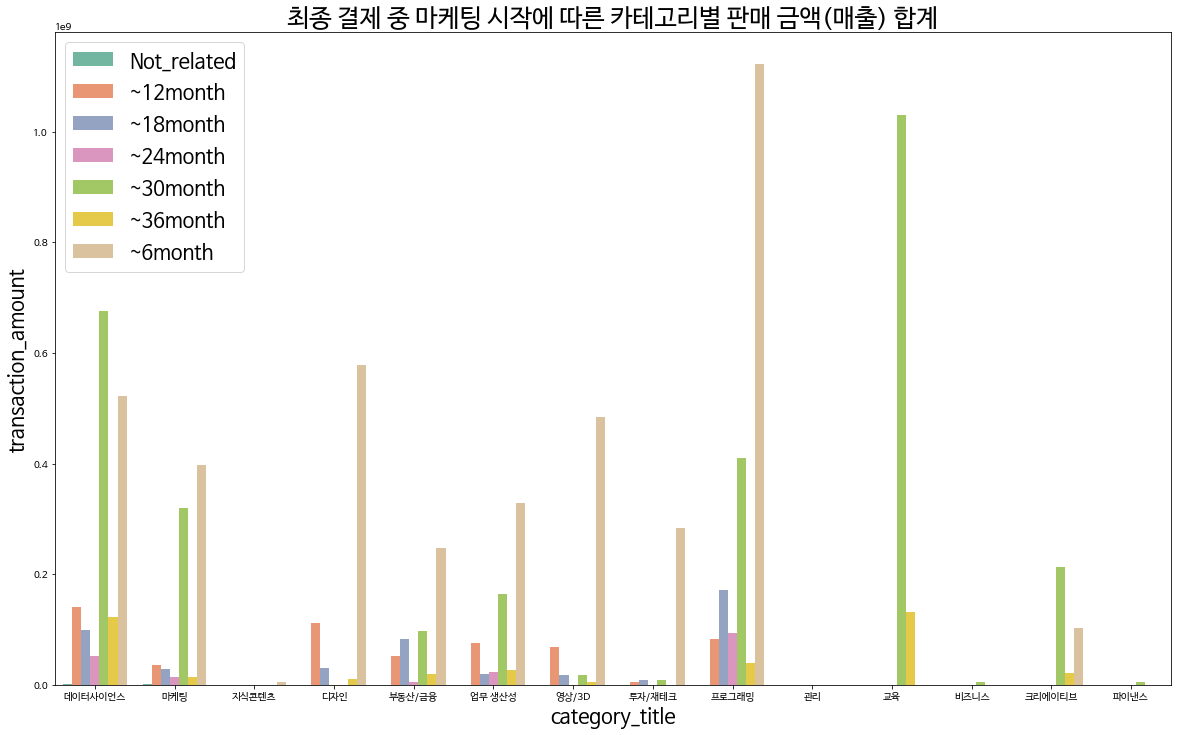

In [ ]:
df_pay_com2 = df_pay_com2.copy()
# 마케팅 시작 날짜, 최종 결제일까지 날짜 month로 계산하여 분류화 -> marketing_effect_month 컬럼 추가


# marketing_start_at 전처리 -> 가장 처음 마케팅 시작한 날짜를 결측치에 대입
display(df_pay_com2.marketing_start_at.describe())
df_pay_com2.loc[df_pay_com2.marketing_start_at.isna(), 'marketing_start_at'] = df_pay_com2.marketing_start_at.min()


df_pay_com2['marketing_effect_month'] = (df_pay_com2.completed_at - df_pay_com2.marketing_start_at).dt.days / 30
def func(x) : 
    if 0 <= x < 7 :
        return '~6month'
    elif 7 <= x < 13 :
        return '~12month'
    elif 13 <= x < 19 :
        return '~18month'
    elif 19 <= x < 25 :
        return '~24month'
    elif 25 <= x < 31 :
        return '~30month'
    elif 31 <= x < 37 :
        return '~36month'
    else :
        return 'Not_related'
df_pay_com2['marketing_term_effect'] = df_pay_com2.marketing_effect_month.map(func)
df_pay_com2.head()
# 구매 확정 중 마케팅 시작에 따른 카테고리별 판매 금액(매출) 합계 (환불 고려 X)
a = df_pay_com2.groupby(['marketing_term_effect', 'category_title']).agg({'transaction_amount' : np.sum})
a = a.reset_index() # 피벗테이블 데이터프레임화하여 시각화

plt.figure(figsize=(20,12))
sns.barplot(data=a, x = a.category_title, y = a.transaction_amount, hue = 'marketing_term_effect', palette = 'Set2')
plt.title('최종 결제 중 마케팅 시작에 따른 카테고리별 판매 금액(매출) 합계', fontsize = 25)
plt.xlabel('category_title', fontsize = 20)
plt.ylabel('transaction_amount', fontsize = 20)
plt.legend(fontsize=20)
plt.show()

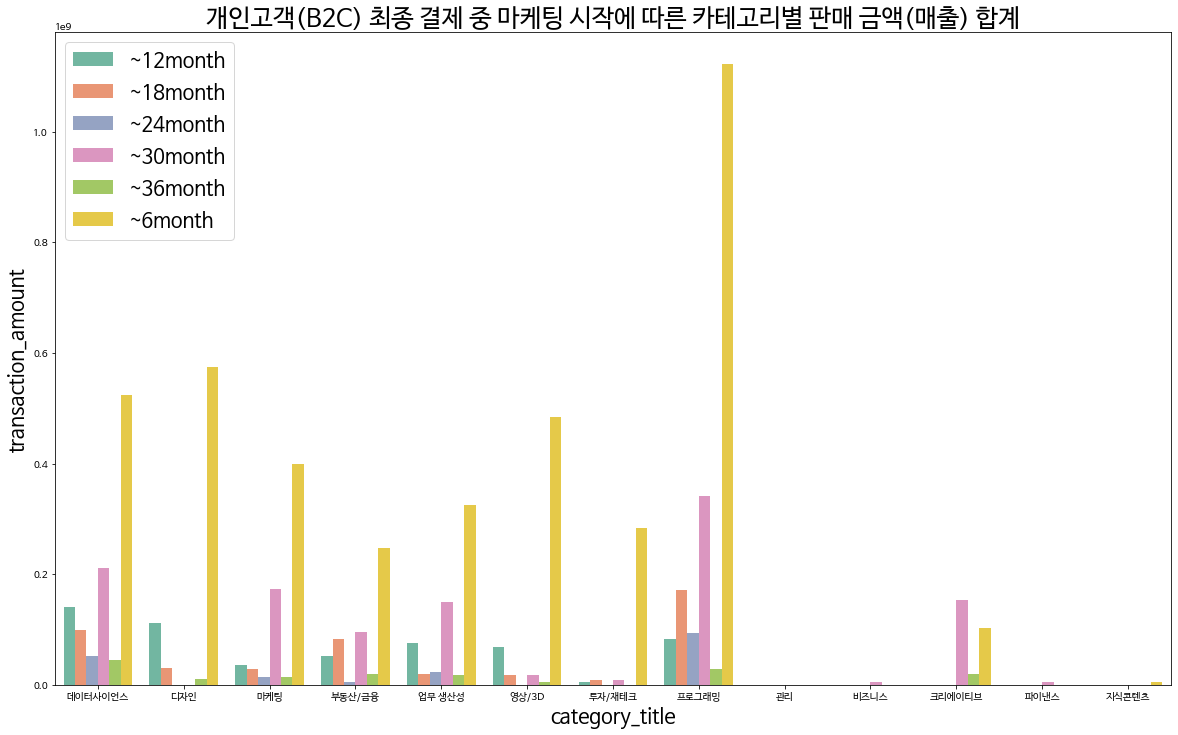

In [ ]:
df_pc_b2c = df_pc_b2c.copy()

# marketing_start_at 전처리 -> 가장 처음 마케팅 시작한 날짜를 결측치에 대입
df_pc_b2c.loc[df_pc_b2c.marketing_start_at.isna(), 'marketing_start_at'] = df_pc_b2c.marketing_start_at.min()

# 확인해보니 12시간 차이 나지 않는 내용들. marketing_start_at = completed_at 처리
df_pc_b2c.loc[df_pc_b2c.marketing_start_at > df_pc_b2c.completed_at, 'marketing_start_at'] = df_pc_b2c.completed_at

# 마케팅 시작 날짜, 최종 결제일까지 날짜 month로 계산하여 분류화 -> marketing_effect_month 컬럼 추가
df_pc_b2c['marketing_effect_month'] = (df_pc_b2c.completed_at - df_pc_b2c.marketing_start_at).dt.days / 30

df_pc_b2c['marketing_term_effect'] = df_pc_b2c.marketing_effect_month.map(func)


# 개인고객(B2C) 구매 확정 중 마케팅 시작에 따른 카테고리별 판매 금액(매출) 합계 (환불 고려 X) 
b = df_pc_b2c.groupby(['marketing_term_effect', 'category_title']).agg({'transaction_amount' : np.sum})
b = b.reset_index() # 피벗테이블 데이터프레임화하여 시각화

plt.figure(figsize=(20,12))
sns.barplot(data=b, x = b.category_title, y = b.transaction_amount, hue = 'marketing_term_effect', palette = 'Set2')
plt.title('개인고객(B2C) 최종 결제 중 마케팅 시작에 따른 카테고리별 판매 금액(매출) 합계', fontsize = 25)
plt.xlabel('category_title', fontsize = 20)
plt.ylabel('transaction_amount', fontsize = 20)
plt.legend(fontsize=20)
plt.show()

분석 - MAU (Monthly Active Users)


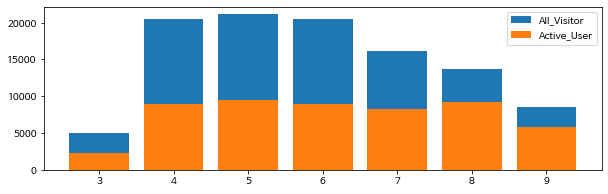

              Active_User  All_Visitor  Percentage
monthbymonth                                      
3                    2275         4972       45.76
4                    8973        20531       43.70
5                    9485        21097       44.96
6                    8916        20464       43.57
7                    8228        16097       51.12
8                    9270        13756       67.39
9                    5752         8502       67.65

The best month was [9]
잠재적 고객이 많음을 확인할 수 있다.


In [ ]:
print("분석 - MAU (Monthly Active Users)")
df_count = df_pay_com.copy()
df_count['Active_User']=1        #컬럼 추가
df_count['monthbymonth'] = df_count['completed_at'].dt.month
y = df_count.groupby('monthbymonth')['Active_User'].sum()
x = df_count['monthbymonth'].unique()
aa = df_count.groupby('monthbymonth')['Active_User'].sum()  .to_frame()  # pandas.series --> dataframe
df_origin2 = df_origin.copy()  # 원본 데이터 불러오기
df_origin2['all_visitor']=1        #컬럼 추가
df_origin2['monthbymonth'] = df_origin2['completed_at'].dt.month
bb = df_origin2.groupby('monthbymonth')['all_visitor'].sum()
aa['All_Visitor'] = bb
aa['Percentage'] = round( aa['Active_User'] / aa['All_Visitor'] * 100 , 2 )
plt.figure(figsize=(10, 3))
plt.bar(x, bb, label="All_Visitor")
plt.bar(x, y, label="Active_User")
plt.legend(loc="upper right")
plt.show()
#결론
print( aa )
print( "\nThe best month was " + str( aa[aa['Percentage'] == aa['Percentage'].max()]  .index.values )  )   # argmax
print("잠재적 고객이 많음을 확인할 수 있다.")

In [ ]:
print("고과금 유저 Top 3")
df_count = df_pay_com.copy()
print( df_count.groupby('customer_id')['transaction_amount'].mean() .sort_values(ascending=False).head(3)  )
print()
print("VVIP id 는 :"+ str(df_count.groupby('customer_id')['transaction_amount'].mean() .sort_values(ascending=False).head(3).index[0])  )

고과금 유저 Top 3
customer_id
512983.0    113400000.0
548381.0     81040000.0
589392.0     58100000.0
Name: transaction_amount, dtype: float64

VVIP id 는 :512983.0


분석 - Daily Purchase Count


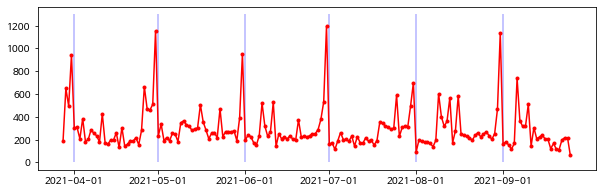


peak들이 주로 월말에 있다
daybyday
2021-06-30    1193
2021-04-30    1155
2021-08-31    1136
2021-05-31     953
2021-03-31     942
Name: count, dtype: int64


In [ ]:
print("분석 - Daily Purchase Count")
df_count = df_pay_com.copy()
df_count['count']=1        #컬럼 추가
df_count['daybyday'] = df_count['completed_at'].dt.date
df_count["daybyday"]=df_count["daybyday"].values.astype(str)   # <class 'datetime.date'> --> str   안하면 비교연산 불가
y = df_count.groupby('daybyday')['count'].sum()
x = df_count['daybyday'].unique()
plt.figure(figsize=(10, 3))
plt.plot(x, y, 'r.-')
plt.xticks( ['2021-04-01','2021-05-01','2021-06-01','2021-07-01','2021-08-01','2021-09-01'] )
plt.vlines(x = '2021-04-01', ymin = 0, ymax = 1300, color ='b', alpha=0.3)
plt.vlines(x = '2021-05-01', ymin = 0, ymax = 1300, color ='b', alpha=0.3)
plt.vlines(x = '2021-06-01', ymin = 0, ymax = 1300, color ='b', alpha=0.3)
plt.vlines(x = '2021-07-01', ymin = 0, ymax = 1300, color ='b', alpha=0.3)
plt.vlines(x = '2021-08-01', ymin = 0, ymax = 1300, color ='b', alpha=0.3)
plt.vlines(x = '2021-09-01', ymin = 0, ymax = 1300, color ='b', alpha=0.3)
plt.show()
print( "\npeak들이 주로 월말에 있다" )
print( df_count.groupby('daybyday')['count'].sum() .sort_values(ascending=False).head(5) )

분석 - 요일별 사용자 수


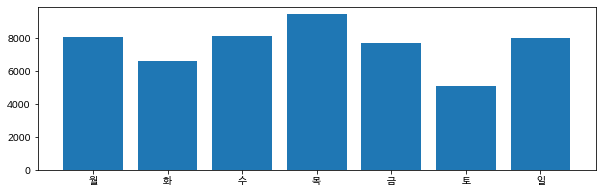

요일 중 가장 고객이 많은 날은 목요일


In [ ]:
print("분석 - 요일별 사용자 수")
df_count = df_pay_com.copy()
df_count['weekdays'] =  df_count['completed_at'].dt.weekday   # numpy.int64
요일 = ['월', '화', '수', '목', '금', '토', '일']
def func(x) :
  return 요일[x]
df_count['요일별'] = df_count['weekdays'] .apply(func)
df_count['count']=1        #컬럼 추가
y = df_count.groupby('요일별')['count'].sum()  #transaction_amount
plt.figure(figsize=(10, 3))
plt.bar(요일, y)
plt.show()
print("요일 중 가장 고객이 많은 날은 "+요일[y.argmax()] + "요일")

분석 - 시간별 사용자 수


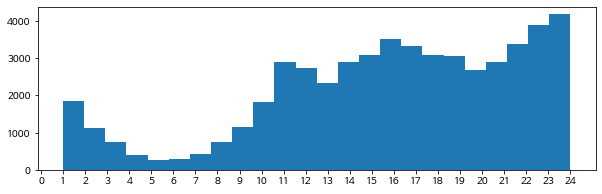

In [ ]:
print("분석 - 시간별 사용자 수")
df_count = df_pay_com.copy()
df_count['hours'] =  df_count['completed_at'].dt.hour + 1   # numpy.int64
plt.figure(figsize=(10, 3))
plt.hist(df_count['hours'], bins=24)
plt.xticks( [num for num in range(0,25)] )
plt.show()

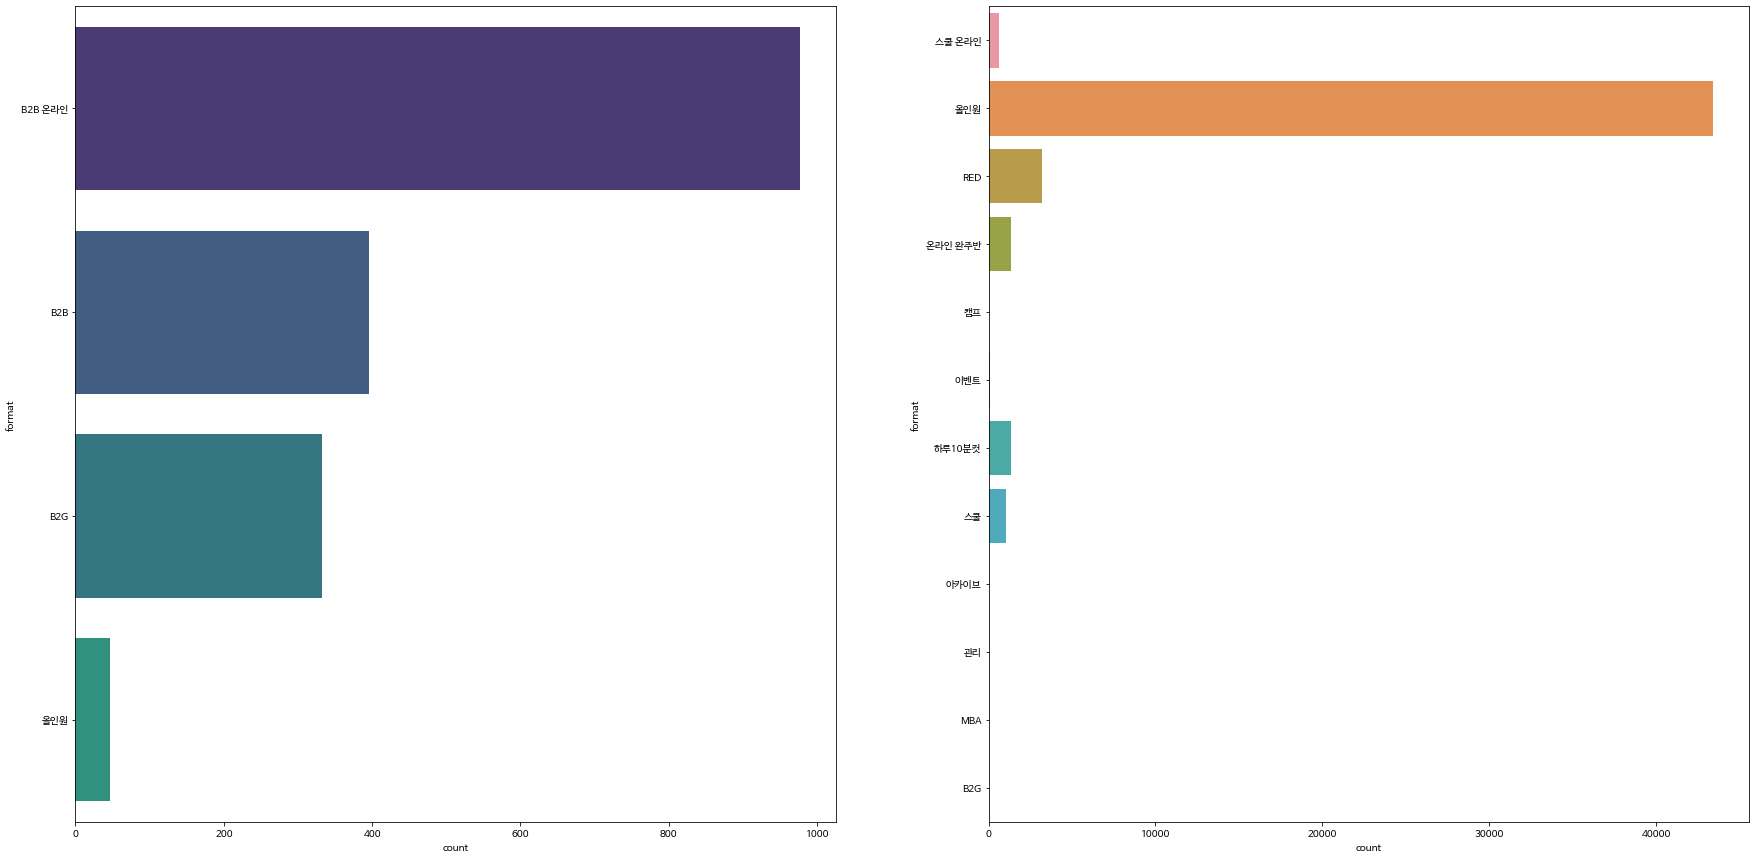

In [ ]:
df_pc_b2b = df_pc_b2b.copy()
plt.figure(figsize=(30, 15))
plt.subplot(1, 2, 1)
sns.set_palette("viridis")
sns.countplot(data=df_pc_b2b, y="format")
plt.subplot(1, 2, 2)
sns.set_palette("viridis")
sns.countplot(data=df_pc_b2c, y="format")
plt.show()

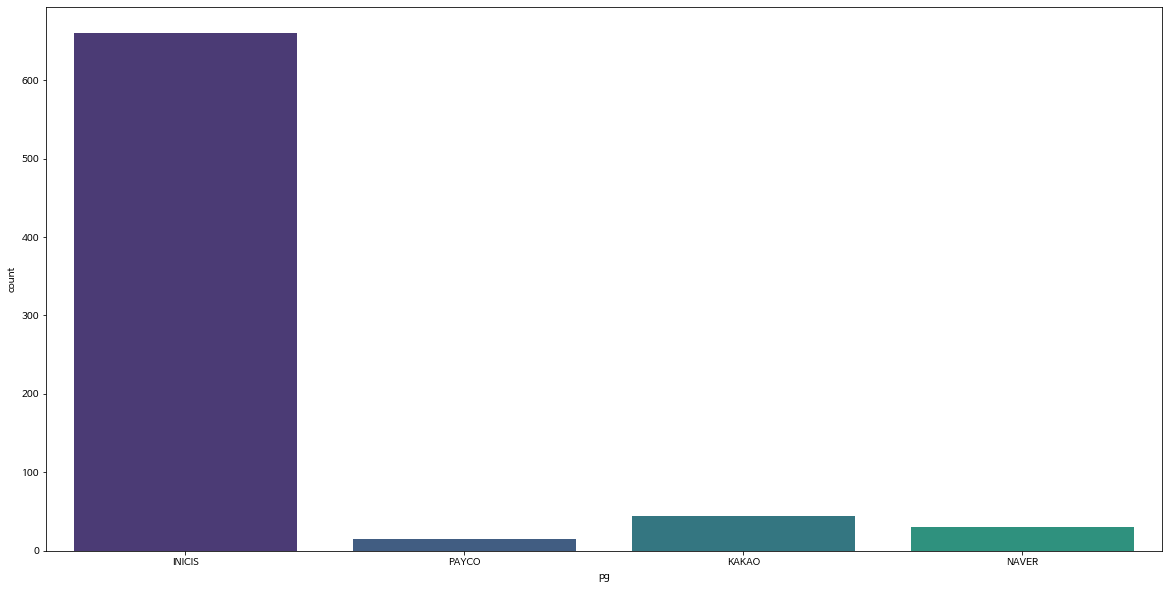

In [ ]:
#B2B 결제 모듈 횟수
plt.figure(figsize=(20, 10))
sns.set_palette("viridis")
sns.countplot(data=df_pc_b2b, x="pg")
plt.show()

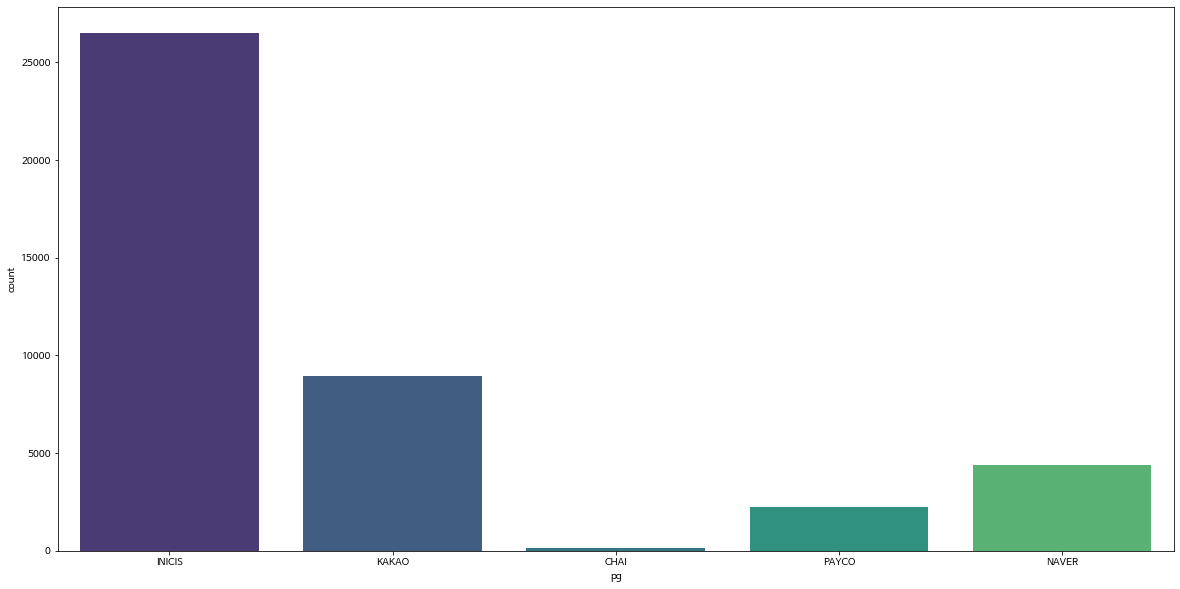

In [ ]:
#B2C 결제 모듈 횟수
plt.figure(figsize=(20, 10))
sns.set_palette("viridis")
sns.countplot(data=df_pc_b2c, x="pg")
plt.show()

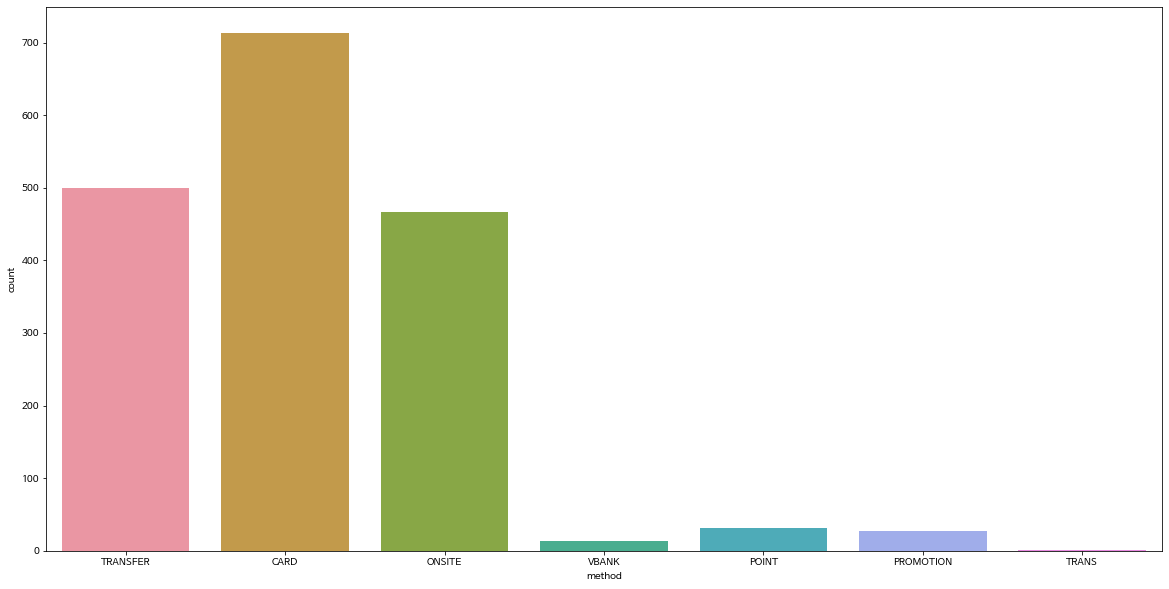

In [ ]:
#B2B 결제 모듈 횟수
plt.figure(figsize=(20, 10))
sns.set_palette("viridis")
sns.countplot(data=df_pc_b2b, x="method")
plt.show()

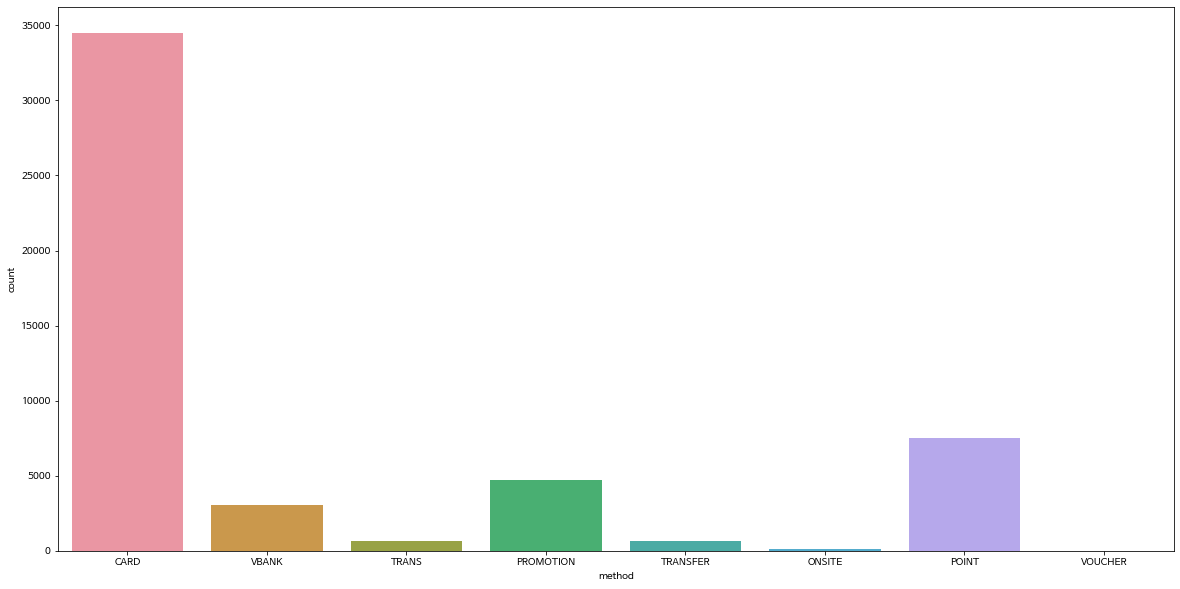

In [ ]:
#B2B 결제 모듈 횟수
plt.figure(figsize=(20, 10))
sns.set_palette("viridis")
sns.countplot(data=df_pc_b2c, x="method")
plt.show()

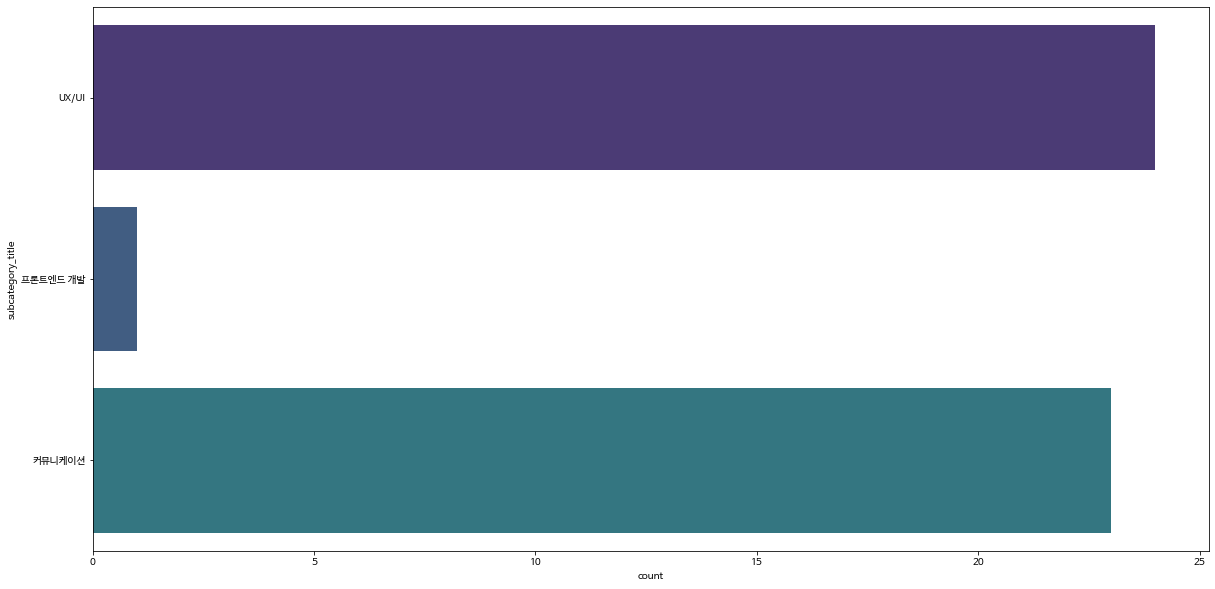

In [ ]:
# B2B 중분류
plt.figure(figsize=(20, 10))
sns.set_palette("viridis")
sns.countplot(data=df_pc_b2b, y="subcategory_title")
plt.show()

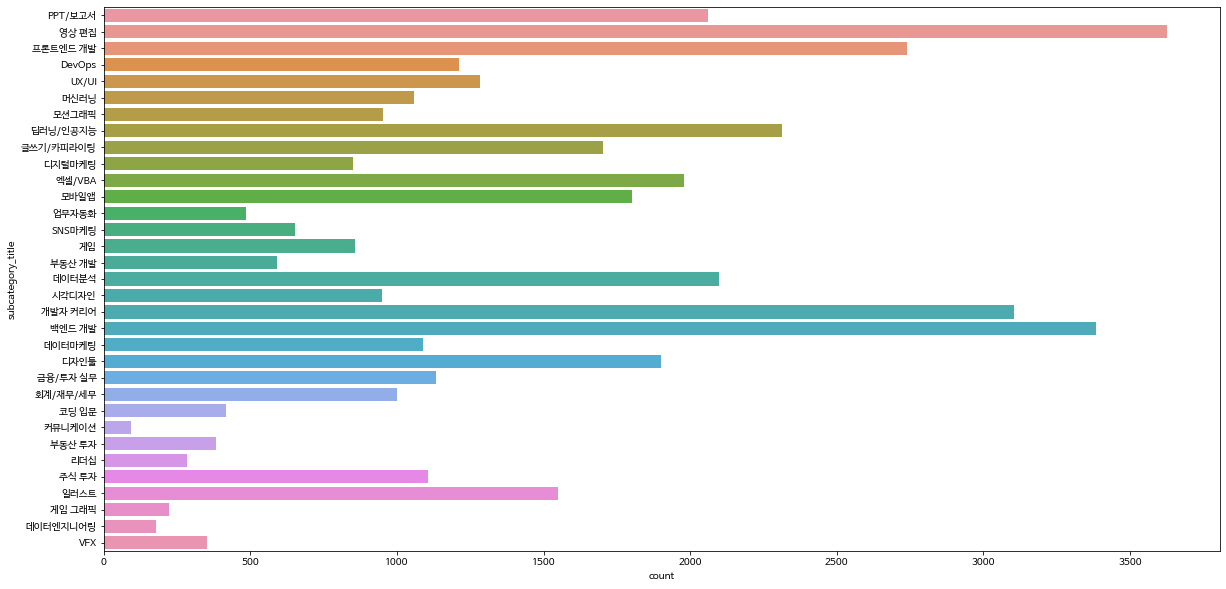

In [ ]:
# B2C 중분류
plt.figure(figsize=(20, 10))
sns.set_palette("viridis")
sns.countplot(data=df_pc_b2c, y="subcategory_title")
plt.show()

In [ ]:
print("B2B 쿠폰사용건수, B2C 쿠폰사용건수")
print(df_pc_b2b['coupon_title'].count(), "\t\t",
      df_pc_b2c['coupon_title'].count())
print("B2B 총건수, B2C 총건수")
print(len(df_pc_b2b), "\t\t",
      len(df_pc_b2c))
print("B2B 쿠폰사용비율, B2C 쿠폰사용비율")
print(round((df_pc_b2b['coupon_title'].count()/len(df_pc_b2b))*100,2), "\t\t",
      round(df_pc_b2c['coupon_title'].count()/len(df_pc_b2c)*100,2)    )

B2B 쿠폰사용건수, B2C 쿠폰사용건수
48 		 23713
B2B 총건수, B2C 총건수
1752 		 51147
B2B 쿠폰사용비율, B2C 쿠폰사용비율
2.74 		 46.36


In [ ]:
from collections import Counter
Counter(df['customer_id']).most_common(10)

[(98685.0, 78),
 (50769.0, 62),
 (40783.0, 59),
 (496508.0, 54),
 (23171.0, 51),
 (427973.0, 51),
 (158374.0, 47),
 (20784.0, 47),
 (106662.0, 45),
 (276705.0, 44)]

In [ ]:
vip1 = df[df['customer_id'] == 98685.0].loc[:,['type','state','course_title','category_title','completed_at','transaction_amount','coupon_discount_amount','sale_price']]
vip1['Month'] = vip1['completed_at'].dt.month
vip1.loc[df['coupon_discount_amount'] != df['coupon_discount_amount'], 'coupon_discount_amount'] = 0
vip1['Month'] = df['completed_at'].dt.month
vip1.groupby('Month')[['sale_price','transaction_amount','coupon_discount_amount']].sum()

,sale_price,transaction_amount,coupon_discount_amount
Month,,,
4,1716600.0,1161300,516700.0
5,317300.0,277300,10000.0
6,1257000.0,950600,129600.0
7,2376000.0,2116500,180300.0
8,3130900.0,2411200,861600.0
9,2825000.0,2620850,204150.0


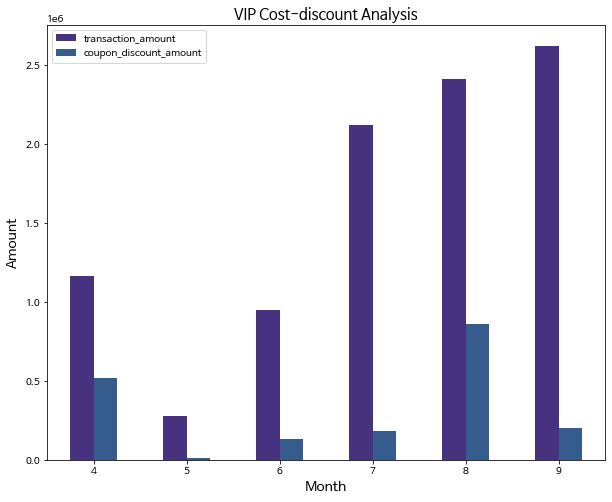

In [ ]:
df = df_origin.copy()
vip1 = df[df['customer_id'] == 98685.0].loc[:,['type','state','course_title','category_title','completed_at','transaction_amount','coupon_discount_amount','sale_price']]
vip1['Month'] = vip1['completed_at'].dt.month
vip1.loc[df['coupon_discount_amount'] != df['coupon_discount_amount'], 'coupon_discount_amount'] = 0
vip1['Month'] = df['completed_at'].dt.month
vip1.groupby('Month')[['sale_price','transaction_amount','coupon_discount_amount']].sum()


#결제-완료 비용과 환불-완료 비용 정리
vip1_con1 = (vip1['type'] == 'PAYMENT') & (vip1['state'] == 'COMPLETED') #결제-완료 조건
final_paid = int(vip1[vip1_con1]['transaction_amount'].sum()) #결제-완료 비용
vip1_con2 = (vip1['type'] == 'REFUND') & (vip1['state'] == 'COMPLETED') #환불-완료 조건
final_refund = int(vip1[vip1_con2]['transaction_amount'].sum()) #환불-완료 비용(마이너스 값)
#결제완료 비용에서 환불완료 비용 차감
paid_refun = final_paid  + final_refund

#디스카운트 비용 정리
vip1_disc = int(vip1[vip1_con1]['coupon_discount_amount'].sum()) #결제-완료의 쿠폰 디스카운트
vip1_refund_disc = int(vip1[vip1_con2]['coupon_discount_amount'].sum()) #환불-완료의 쿠폰 디스카운트
#결제완료 할인에서 환불완료 할인 차감
final_refun_disc = vip1_disc + vip1_refund_disc

#강의 원가
vip1_sales = int(vip1[vip1_con1]['sale_price'].sum()) #결제-완료의 강의원가
vip1_sales_refund = int(vip1[vip1_con2]['sale_price'].sum()) #환불-완료의 강의원가(마이너스값)
#찐강의 비용
final_sales = vip1_sales + vip1_sales_refund 

vip1['Month'] = df['completed_at'].dt.month
vip1.groupby('Month')[['transaction_amount','coupon_discount_amount']].sum().plot(kind='bar', figsize=(10,8))

plt.title('VIP Cost-discount Analysis', fontsize=15)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Amount', fontsize=14)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.legend()

plt.show()


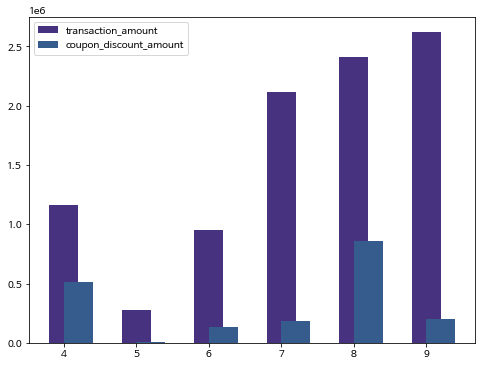

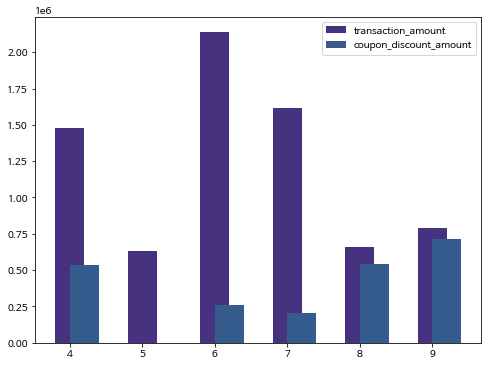

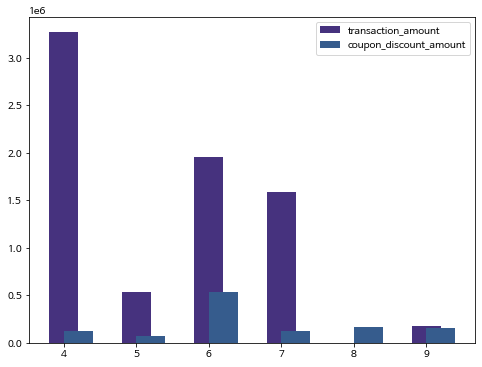

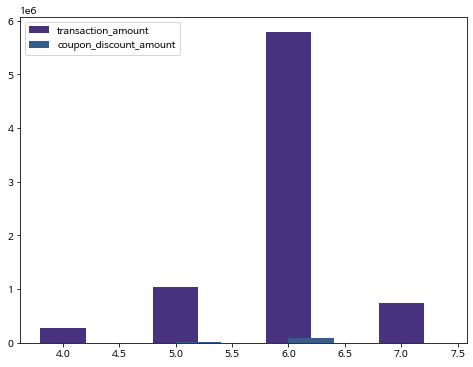

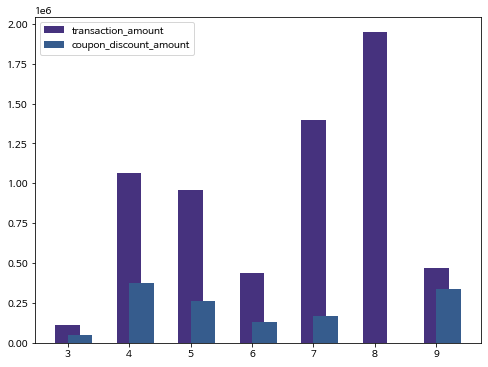

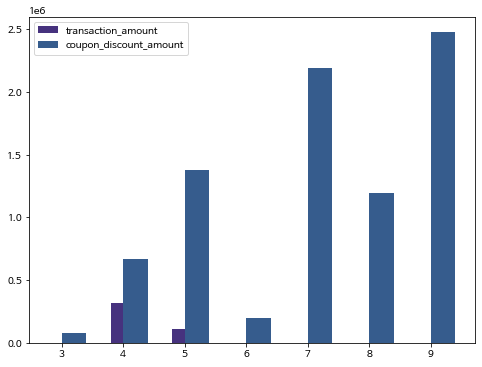

In [ ]:
df1 = df.copy()
df1['Month'] = df['completed_at'].dt.month
vip_cond = [98685.0, 50769.0, 40783.0, 496508.0, 23171.0,427973.0]

for i in vip_cond:
  # vip_list[i][0]
  vip_cond = df1['customer_id'] == i
  vip = df1[vip_cond]
  vip_x_data = vip.groupby('Month')[['transaction_amount','coupon_discount_amount']].sum()           

  x = vip_x_data.index.values
  y2 = vip_x_data ['transaction_amount']
  y3 = vip_x_data ['coupon_discount_amount']

  plt.figure(figsize=(8,6))
  plt.bar(x, y2, width=0.4, label="transaction_amount")
  plt.bar(x +0.2, y3, width=0.4, label="coupon_discount_amount")

  plt.legend()
  plt.show()